# Data Separation

Author: Gillian A. McGinnis, final-semester M.S. Information Science - Machine Learning  
The University of Arizona College of Information  
INFO 698 - Capstone  
Start date: 21 October 2025  
Last updated: 21 October 2025

In [1]:
"""
Module providing code for test/train split and sliding window creation. Relies on 01_eda.ipynb completion.
"""

'\nModule providing code for test/train split and sliding window creation. Relies on 01_eda.ipynb completion.\n'

## Setup

### Packages

In [2]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# # import matplotlib.ticker as ticker
# import matplotlib.dates as mdates
# import datetime as dt
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score

In [3]:
## (Optional chunk)
# Current session information
import session_info
session_info.show(dependencies=False)

### Data

In [4]:
united_water = pd.read_parquet('data/clean/water.parquet')
united_soil = pd.read_parquet('data/clean/soil.parquet')

## Prepare

## Feature Engineering

In [5]:
# Select columns of interest
data_water = united_water.drop(columns=['raw_rain', 'chk_note_rain', 'chk_fail_rain', 'chk_note_ro', 'chk_fail_ro', 'comment_ro', 'source_ro'])

In [6]:
### Note ###
# Remove this later -- just a smaller subset for feature engineering testing!!
data_water = data_water['2015-01-01 00:00:00':'2016-12-31 23:59:59']
######

Create feature which tracks how recent a calibration was conducted.

In [7]:
# Create index of instances where there is a calibration point
cal_instances = data_water['weir_level_cal'].notna()
# Create groupings based on most recent instance
cal_group_id = cal_instances.cumsum()
# Create new column to count number of records since the calibration point
# which resets to 0 at each new calibration
data_water['records_since_cal'] = data_water.groupby(cal_group_id).cumcount()

# Clean up environment
del cal_instances, cal_group_id

# data_water

Create feature which tracks how recent a rain event occurred.

In [8]:
# Create index of instances where there is a calibration point
rain_instances = data_water['ra_rain'].notna()
# Create groupings based on most recent instance
rain_group_id = rain_instances.cumsum()
# Create new column to count number of records since the calibration point
# which resets to 0 at each new calibration
data_water['records_since_rain'] = data_water.groupby(rain_group_id).cumcount()

# Clean up environment
del rain_instances, rain_group_id

# Replace NAs with 0
data_water['ra_rain'] = data_water['ra_rain'].fillna(0)

data_water.sample(10)
# data_water.dropna(subset='raw_ro')

,weir_level_cal,ra_rain,level_ro,raw_ro,obstruction_ro,gap_fill_ro,weir_cleaning_ro,spike_ro,calibration_ro,records_since_cal,records_since_rain
datetime,,,,,,,,,,,
2015-12-22 17:05:00,NaN,0.000,32.93,40.1,True,False,False,False,False,100,273
2016-01-04 02:20:00,NaN,0.000,28.20,28.2,False,False,False,False,False,1081,866
2016-09-18 21:30:00,NaN,0.000,40.47,48.1,True,False,False,False,False,735,68
2016-08-25 15:40:00,NaN,3.556,63.10,63.1,False,False,False,False,False,75,0
2016-06-22 22:50:00,NaN,0.000,31.90,31.9,False,False,False,False,False,165,3
2015-06-19 13:10:00,NaN,0.000,14.50,14.5,False,False,False,False,False,343,526
2015-11-15 16:40:00,NaN,0.000,44.70,44.7,False,False,False,False,False,667,89
2016-12-25 19:05:00,NaN,0.000,61.60,61.6,False,False,False,False,False,701,54
2015-07-01 12:20:00,NaN,0.000,3.50,3.5,False,False,False,False,False,47,434


Lag features: rain

In [9]:
def lag_feats(input_df, input_cols, input_lags):
    output_df = input_df.copy()
    for col in input_cols:
        for lag in input_lags:
            output_df[f"{col}_lag{lag}"] = output_df[col].shift(lag)
    return output_df

In [10]:
# lag_feats(data_water, ['raw_ro'], [1, 2, 3, 24]).dropna(subset='raw_ro')[['raw_ro', 'raw_ro_lag1', 'raw_ro_lag2']]
# lag_feats(data_water, ['raw_ro'], [1, 2, 3, 24]).dropna(subset='raw_ro')[['raw_ro', 'raw_ro_lag1', 'raw_ro_lag24']]

# Columns to get temporal stats on
cols_to_shift = ['raw_ro', 'ra_rain']
# data at 5-min increments -- lag to record values at 5m, 10m, 15m, 30m, 1h, and 2h prior
lags_of_interest = [1, 2, 3, 6, 12, 24]

data_water = lag_feats(data_water, cols_to_shift, lags_of_interest)

data_water.sample(10)

,weir_level_cal,ra_rain,level_ro,raw_ro,obstruction_ro,gap_fill_ro,weir_cleaning_ro,spike_ro,calibration_ro,records_since_cal,...,raw_ro_lag3,raw_ro_lag6,raw_ro_lag12,raw_ro_lag24,ra_rain_lag1,ra_rain_lag2,ra_rain_lag3,ra_rain_lag6,ra_rain_lag12,ra_rain_lag24
datetime,,,,,,,,,,,,,,,,,,,,,
2016-12-26 12:05:00,NaN,0.000,57.20,57.2,False,False,False,False,False,905,...,57.0,57.4,57.2,58.9,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-17 13:20:00,NaN,0.000,0.00,0.0,False,False,False,False,False,62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-23 14:00:00,NaN,0.000,16.20,16.2,False,False,False,False,False,642,...,16.3,15.9,16.2,16.2,0.0,0.0,0.0,0.0,0.0,0.0
2015-09-18 18:05:00,NaN,0.254,35.70,35.7,False,False,False,False,False,116,...,36.0,35.8,35.7,35.1,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-18 18:55:00,NaN,0.000,0.00,0.0,False,False,False,False,False,412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-10-26 17:35:00,NaN,0.000,51.39,51.4,True,False,False,False,False,107,...,51.5,51.5,51.1,51.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 13:20:00,NaN,0.254,8.10,8.1,False,False,False,False,False,53,...,7.7,8.1,8.4,9.8,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-17 14:55:00,NaN,0.000,0.00,0.0,False,False,False,False,False,76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-09 12:20:00,NaN,0.000,0.00,0.0,False,False,False,False,False,332,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
def rolling_feats(input_df, input_cols, input_windows):
    output_df = input_df.copy()
    for col in input_cols:
        for window in input_windows:
            output_df[f"{col}_rollmean_{window}"] = output_df[col].rolling(window).mean()
            output_df[f"{col}_rollstd_{window}"] = output_df[col].rolling(window).std()
            output_df[f"{col}_rollslope_{window}"] = (output_df[col].rolling(window).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0], raw=True))
    return output_df

In [12]:
# data_water_mini = data_water['1990-01-01 00:00:00':'1990-01-30 23:59:59']
# rolling_feats(data_water_mini, cols_to_lag, [6, 12, 36])
# 30m, 1h, 6h
windows_of_interest = [6, 12, 72]


data_water = rolling_feats(data_water, cols_to_shift, windows_of_interest)

data_water.sample(10)

,weir_level_cal,ra_rain,level_ro,raw_ro,obstruction_ro,gap_fill_ro,weir_cleaning_ro,spike_ro,calibration_ro,records_since_cal,...,raw_ro_rollslope_72,ra_rain_rollmean_6,ra_rain_rollstd_6,ra_rain_rollslope_6,ra_rain_rollmean_12,ra_rain_rollstd_12,ra_rain_rollslope_12,ra_rain_rollmean_72,ra_rain_rollstd_72,ra_rain_rollslope_72
datetime,,,,,,,,,,,,,,,,,,,,,
2015-11-28 10:35:00,NaN,0.0,47.00,47.0,False,False,False,False,False,313,...,-0.028753,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2016-06-10 01:15:00,NaN,0.0,17.30,17.3,False,False,False,False,False,202,...,-0.051892,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2016-06-12 07:15:00,NaN,0.0,8.70,8.7,False,False,False,False,False,555,...,-0.005698,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2016-04-13 06:50:00,NaN,0.0,0.00,0.0,False,False,False,False,False,266,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2016-04-05 16:30:00,NaN,0.0,0.00,0.0,False,False,False,False,False,94,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2015-12-20 06:30:00,NaN,0.0,37.35,50.3,True,False,False,False,False,552,...,0.038019,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2016-07-05 18:30:00,NaN,0.0,73.30,73.3,False,False,False,False,False,114,...,-0.168006,0.0,0.0,0.0,0.0,0.0,0.0,0.007056,0.042034,-0.000539
2015-05-10 09:35:00,NaN,0.0,0.00,0.0,False,False,False,False,False,586,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2015-11-29 10:50:00,NaN,0.0,49.40,49.4,False,False,False,False,False,604,...,-0.012547,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


Change since last value

In [13]:
data_water['raw_ro_change'] = data_water['raw_ro'].diff()

# cal_na_mask = data_water['weir_level_cal'].notna() & data_water['raw_ro'].notna()
# # cal_na_mask
# (data_water['weir_level_cal'] - data_water['raw_ro']).dropna()
# del cal_na_mask
data_water['diff_ro_call'] = (data_water['weir_level_cal'] - data_water['raw_ro'])
# data_water['rain_diff']

data_water.sample(10)

,weir_level_cal,ra_rain,level_ro,raw_ro,obstruction_ro,gap_fill_ro,weir_cleaning_ro,spike_ro,calibration_ro,records_since_cal,...,ra_rain_rollstd_6,ra_rain_rollslope_6,ra_rain_rollmean_12,ra_rain_rollstd_12,ra_rain_rollslope_12,ra_rain_rollmean_72,ra_rain_rollstd_72,ra_rain_rollslope_72,raw_ro_change,diff_ro_call
datetime,,,,,,,,,,,,,,,,,,,,,
2016-09-03 01:30:00,NaN,0.000,40.85,44.7,True,False,False,False,False,205,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.1,NaN
2016-03-10 19:35:00,NaN,0.000,0.00,0.0,False,False,False,False,False,132,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN
2016-09-05 19:50:00,NaN,0.000,35.40,40.0,True,False,False,False,False,134,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.4,NaN
2016-07-04 00:40:00,NaN,0.000,53.40,53.4,False,False,False,False,False,743,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.017639,0.065022,-0.001131,0.0,NaN
2016-03-12 10:50:00,NaN,0.000,0.00,0.0,False,False,False,False,False,317,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN
2016-10-07 15:55:00,NaN,0.000,60.20,60.2,False,False,False,False,False,82,...,0.307609,-0.130629,0.084667,0.225457,0.005329,0.067028,0.180831,0.001556,0.2,NaN
2016-06-14 18:45:00,NaN,0.000,73.30,73.3,False,False,False,False,False,112,...,0.103695,0.021771,0.063500,0.114876,-0.000888,0.779639,1.386194,-0.016846,-0.8,NaN
2016-02-22 22:15:00,NaN,0.000,5.54,5.5,True,False,False,False,False,1027,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.1,NaN
2016-02-06 04:00:00,NaN,0.000,9.74,9.7,True,False,False,False,False,513,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,NaN


In [ ]:
# data_water = data_water.dropna(subset='obstruction_ro')

## DRAFTING

In [ ]:
u_w_mini = united_water.copy()[['weir_level_cal', 'ra_rain']]['2015-01-01 00:00:00':'2015-02-01 00:00:00']
# print(u_w_mini.info())

is_cal = u_w_mini['weir_level_cal'].notna()
g_id = is_cal.cumsum()
# g_id
u_w_mini['records_since_cal'] = u_w_mini.groupby(g_id).cumcount()
del is_cal, g_id

u_w_mini

In [ ]:
# water_m = united_water[['raw_ro', 'level_ro', 'ra_rain', 'obstruction_ro']]['2010-12-28 10:00:00':'2011-01-05 23:59:59']
water_m = united_water[['raw_ro', 'level_ro', 'ra_rain', 'obstruction_ro']]

null_mask = water_m['ra_rain'].isnull()
g_id_event = null_mask.cumsum()
water_m['r_event_sum'] = water_m.groupby(g_id_event)['ra_rain'].cumsum()

is_rain = water_m['ra_rain'].notna()
g_id = is_rain.cumsum()
# g_id
water_m['since_rain'] = water_m.groupby(g_id).cumcount()
water_m['dec'] = np.exp(-0.1*water_m['since_rain'])
water_m['rain_fill'] = water_m['r_event_sum'].ffill()
# data_u['1_shallow_f'] = data_u['1_shallow'].ffill()
water_m['rain_dec'] = (water_m['rain_fill']*water_m['dec'])

# water_m.drop(columns=['level_ro'])
# water_m = water_mini['2010-12-28 10:00:00':'2011-01-05 23:59:59']
# water_m['1992-04-23 18:00:00':'1992-04-23 23:59:59']

In [ ]:
water_mini = pd.merge(
    united_water[['raw_ro', 'level_ro', 'ra_rain', 'obstruction_ro']],
    water_m[['rain_dec', 'since_rain']],
    left_index=True,
    right_index=True,
    # soil_mini_shallow.reset_index(),
    # soil_mini_deep.reset_index(),
    # on = ["date", "sample"],
    # suffixes = ("_shallow", "_deep"),
    how = "outer"
    )
# g_id
# is_rain_event = (water_mini['since_rain'] == 0)
# g_id_rain = is_rain_event.cumsum()
# water_mini.groupby(g_id_rain).cumcount()

del water_m, null_mask, g_id_event, is_rain, g_id

In [ ]:
## Subset for testing
# water_mini = united_water['2010-01-01 00:00:00':'2012-12-31 23:59:59']
# water_mini = united_water.copy()
# water_mini
# water_mini = united_water[['raw_ro', 'level_ro', 'ra_rain', 'obstruction_ro']]

water_mini['ra_rain'] = water_mini['ra_rain'].fillna(0)
water_mini = water_mini.dropna()
water_mini.head()

Calculate distance from previous rainfall

In [ ]:
# w_m = water_mini['1989-07-19 11:55:00':'1991-07-19 11:55:00'].copy()

In [ ]:
# # is_rain = (w_m['ra_rain'] != 0)
# # g_id = is_rain.cumsum()
# # w_m['since_rain'] = w_m.groupby(g_id).cumcount()
# # w_m

# is_rain = (water_mini['ra_rain'] != 0)
# g_id = is_rain.cumsum()
# water_mini['since_rain'] = water_mini.groupby(g_id).cumcount()
# water_mini.head()

# # del is_rain, g_id

In [ ]:
# # g_id
# is_rain_event = (water_mini['since_rain'] == 0)
# g_id_rain = is_rain_event.cumsum()
# water_mini.groupby(g_id_rain).cumcount()

Calculate the difference from previous value

In [ ]:
water_mini['diff_ro'] = water_mini['raw_ro'].diff()
# fix first NA
water_mini['diff_ro'] = water_mini['diff_ro'].fillna(0)
water_mini[['raw_ro', 'diff_ro']].head()

In [ ]:
water_mini['1992-04-23 18:00:00':'1992-04-23 18:30:00']

In [ ]:
# # soil_mini = united_soil[['sample', 'h2o_by_wet_shallow', 'h2o_by_wet_deep']]
# soil_mini = united_soil.copy()
# # soil_mini = soil_mini.reset_index()
# # # soil_mini['sample'] = soil_mini['sample'].astype('category')
# # # soil_mini['dup'] = soil_mini.duplicated()
# # print(len(soil_mini[soil_mini.duplicated()==False]))
# # print(len(soil_mini.drop_duplicates()))
# # # united_soil[united_soil['chk_note_shallow']=='doubtful']
# # # soil_mini['sample'] = soil_mini['sample'].astype('category')
# # # soil_mini = soil_mini[['sample', 'h2o_by_wet_shallow', 'h2o_by_wet_deep']]
# # # soil_mini

In [ ]:
# water_mini = water_mini[['raw_ro', 'level_ro', 'ra_rain', 'obstruction_ro']]
# water_mini

In [ ]:
# len(soil_mini)

## Soil

Pivot the soil data such that each sample has its own columns, and separated by depth.

In [14]:
# Drop irrelevant column
data_soil_shallow = united_soil.copy().drop('h2o_by_wet_deep', axis=1)
# Pivot wider
data_soil_shallow = data_soil_shallow.pivot(columns='sample', values='h2o_by_wet_shallow')

# Drop irrelevant column
data_soil_deep = united_soil.copy().drop('h2o_by_wet_shallow', axis=1)
# Pivot wider
data_soil_deep = data_soil_deep.pivot(columns='sample', values='h2o_by_wet_deep')

# Combine
data_soil = pd.merge(
    data_soil_shallow,
    data_soil_deep,
    left_index = True,
    right_index = True,
    suffixes = ("_shallow", "_deep"),
    how = "outer"
)

del data_soil_shallow, data_soil_deep

data_soil.sample(10)

sample,1_shallow,2_shallow,3_shallow,4_shallow,5_shallow,6_shallow,7_shallow,8_shallow,9_shallow,10_shallow,1_deep,2_deep,3_deep,4_deep,5_deep,6_deep,7_deep,8_deep,9_deep,10_deep
date,,,,,,,,,,,,,,,,,,,,
2007-02-02,30.5,33.2,35.2,34.5,39.9,35.4,34.3,36.8,28.0,27.5,32.9,31.8,32.0,33.3,39.9,36.7,33.7,24.9,27.1,27.6
1990-04-12,32.9,36.3,32.5,34.4,40.5,30.2,32.5,29.7,27.4,27.3,34.8,36.7,31.3,29.4,34.5,27.6,34.2,23.9,26.3,29.1
1996-10-17,41.2,41.6,35.8,40.9,40.1,NaN,43.5,39.1,36.5,49.8,36.1,40.8,33.6,25.4,35.3,28.8,37.5,30.7,30.6,27.9
2018-09-28,41.3,38.4,47.9,39.3,50.2,44.8,37.2,49.1,40.5,37.9,37.1,37.8,44.6,37.2,43.9,44.7,41.0,36.1,37.2,37.0
1998-04-16,25.7,30.6,27.9,29.9,30.9,24.4,29.1,26.8,25.8,26.5,29.4,33.2,28.4,28.7,30.0,30.6,29.9,23.2,27.1,25.5
1993-04-08,29.6,30.3,32.6,31.1,34.1,27.3,32.8,35.4,27.5,27.4,31.1,33.6,28.7,31.5,33.8,29.8,32.3,22.3,28.4,26.3
1994-03-18,28.1,31.7,30.5,28.2,33.5,28.0,31.0,36.3,25.3,26.9,30.3,33.1,27.9,28.8,31.4,26.7,31.5,23.6,26.2,26.3
1995-06-02,38.2,43.7,43.3,39.1,42.9,38.1,40.1,43.5,34.4,36.2,36.4,40.0,35.9,32.5,39.9,32.8,35.5,33.1,30.5,30.6
2006-01-19,36.1,39.5,38.1,43.2,42.1,46.5,40.1,28.9,30.7,34.0,35.2,39.4,34.3,37.0,37.0,42.5,33.8,22.3,30.4,30.6


In [ ]:
# soil_mini_shallow = united_soil.copy().drop('h2o_by_wet_deep', axis=1)
# soil_mini_shallow = soil_mini_shallow.pivot(columns='sample', values='h2o_by_wet_shallow')

# soil_mini_deep = united_soil.copy().drop('h2o_by_wet_shallow', axis=1)
# soil_mini_deep = soil_mini_deep.pivot(columns='sample', values='h2o_by_wet_deep')

# soil_mini = pd.merge(
#     soil_mini_shallow,
#     soil_mini_deep,
#     left_index=True,
#     right_index=True,
#     # soil_mini_shallow.reset_index(),
#     # soil_mini_deep.reset_index(),
#     # on = ["date", "sample"],
#     suffixes = ("_shallow", "_deep"),
#     how = "outer"
#     )

# soil_mini.head()

## Unite

In [15]:
data_united = pd.merge(
    data_water,
    data_soil,
    left_index = True,
    right_index = True,
    how = 'outer'
)

# Extend soil vals
cols_to_fill = [col for col in data_united.columns if (col.endswith('shallow') | col.endswith('deep'))]
data_united[cols_to_fill] = data_united[cols_to_fill].ffill()

data_united.sample(10)

,weir_level_cal,ra_rain,level_ro,raw_ro,obstruction_ro,gap_fill_ro,weir_cleaning_ro,spike_ro,calibration_ro,records_since_cal,...,1_deep,2_deep,3_deep,4_deep,5_deep,6_deep,7_deep,8_deep,9_deep,10_deep
2016-05-23 13:05:00,NaN,0.0,0.00,0.0,False,False,False,False,False,54.0,...,41.0,37.7,41.0,38.3,37.3,44.4,35.3,28.6,33.2,31.8
2015-03-21 05:50:00,NaN,0.0,7.00,7.0,False,False,False,False,False,256.0,...,25.8,21.2,23.3,20.7,23.0,25.2,25.7,22.9,24.7,22.0
2015-07-02 03:30:00,NaN,0.0,0.50,0.5,False,False,False,False,False,229.0,...,37.0,38.1,40.8,34.2,37.8,42.5,34.9,27.9,32.6,30.5
2015-10-24 04:10:00,NaN,0.0,79.00,79.0,False,False,False,False,False,524.0,...,40.2,34.2,40.6,38.9,41.1,45.7,36.6,34.2,35.6,31.3
2015-06-08 13:05:00,NaN,0.0,20.60,20.6,False,False,False,False,False,53.0,...,36.9,33.1,37.3,38.0,38.2,43.7,34.8,34.1,37.7,30.3
2016-02-10 04:20:00,NaN,0.0,12.02,12.1,True,False,False,False,False,524.0,...,33.7,33.1,34.5,29.8,34.3,38.4,29.5,22.8,28.8,27.1
2016-03-25 05:15:00,NaN,0.0,0.00,0.0,False,False,False,False,False,251.0,...,26.9,21.4,27.7,22.0,21.5,29.8,23.1,21.9,25.8,23.0
2015-10-02 08:50:00,NaN,0.0,73.90,73.9,False,False,False,False,False,4.0,...,37.7,36.1,40.2,33.1,38.4,43.3,34.7,24.1,34.6,30.8
2015-02-26 00:10:00,NaN,0.0,18.60,18.6,False,False,False,False,False,191.0,...,40.6,31.0,39.0,28.7,36.5,39.9,31.9,26.2,32.6,28.7
2016-10-14 02:20:00,NaN,0.0,86.80,86.8,False,False,False,False,False,217.0,...,39.6,40.7,47.1,41.9,47.7,41.7,39.8,27.2,35.9,38.8


### DRAFTING2

In [ ]:
# water_mini_test = water_mini['1990-01-01 00:00:00':'1992-12-31 23:23:59']
# print(len(water_mini_test))
# soil_mini_test = soil_mini['1990-01-01 00:00:00':'1992-12-31 23:23:59']

In [ ]:
data_united = pd.merge(
    water_mini,
    soil_mini,
    left_index=True,
    right_index=True,
    # soil_mini_shallow.reset_index(),
    # soil_mini_deep.reset_index(),
    # on = ["date", "sample"],
    # suffixes = ("_shallow", "_deep"),
    how = "outer"
    )

# mini_mini_test = mini_test['1992-04-09 00:00:00':'1992-04-09 23:23:59']
# mini_mini_test
# mini_test['soil_stale'] = 
data_united.head()

In [ ]:
data_u = data_united['1989-07-19 11:55:00':'1989-08-15 00:00:00']

In [ ]:
# data_u = data_united['1989-07-19 11:55:00':'1989-08-15 00:00:00']
data_u = data_u[['raw_ro', '1_shallow', '2_shallow']]
# cols_to_check = [col for col in data_u.columns if (col.endswith('shallow') | col.endswith('deep'))]
# is_soil = data_u[cols_to_check].notna()
# g_id = is_soil.cumsum()
# g_id

col_to_check = "1_shallow"
is_soil = data_u[col_to_check].notna()
g_id = is_soil.cumsum()
# g_id
data_u['since_soil'] = data_u.groupby(g_id).cumcount()
data_u['dec'] = np.exp(-0.001*data_u['since_soil'])
data_u['1_shallow_f'] = data_u['1_shallow'].ffill()
data_u['1_shallow_w'] = (data_u['1_shallow_f']*data_u['dec'])
data_u

# finding most freq
# g_id['most'] = g_id.mode(axis=1)[0]
# data_u['since_soil'] = data_u.groupby(g_id).cumcount()
# data_u

# g_id = is_rain.cumsum()
# water_mini['since_rain'] = water_mini.groupby(g_id).cumcount()
# water_mini.head()
del col_to_check, is_soil, g_id, data_u

In [ ]:
cols_to_fill = [col for col in data_united.columns if (col.endswith('shallow') | col.endswith('deep'))]
data_united[cols_to_fill] = data_united[cols_to_fill].ffill()
## Only fill for the exact day the measurement was taken
# data_united[cols_to_fill] = data_united[cols_to_fill].groupby(pd.Grouper(freq='D')).ffill()
data_united = data_united.dropna(subset='obstruction_ro')
data_united.head()

In [ ]:
# # data_united['1989-07-19 11:55:00':'1989-07-30 11:55:00']
# # data_united[data_united['obstruction_ro']==True]
# data_u = data_united['2010-12-28 10:00:00':'2011-01-05 23:59:59']
# data_u['rain_event']
# # data_united[data_united['since_rain']==0]

### Train/Test (80/20)

In [16]:
# # mini_xy = water_mini[['level_ro', 'raw_ro', 'chk_note_ro', 'source_ro']].dropna()
# mini_xy = water_mini.copy().drop('level_ro', axis=1).dropna()
# mini_y = mini_xy['obstruction_ro']
# # mini_x = mini_xy[['raw_ro', 'chk_note_ro', 'source_ro']]
# mini_x = mini_xy.drop('obstruction_ro', axis=1)
# mini_xy
var_of_interest = 'obstruction_ro'
y_drops = ['level_ro', 'obstruction_ro', 'gap_fill_ro', 'weir_cleaning_ro', 'spike_ro', 'calibration_ro']

data_filtered = data_united.copy().dropna(subset = var_of_interest)
# y_drops.remove(var_of_interest)

united_y = data_filtered[var_of_interest]
# united_x = data_united.drop([var_of_interest, 'level_ro'], axis=1)
united_x = data_filtered.drop(y_drops, axis=1)
# united_x.info()

del data_filtered

# united_x.info()

# united_x.info()

In [17]:
print("Test:\t20p of", len(united_y), "is", round(.2*len(united_y)))
print("Train:\t80p of", len(united_y), "is", round(.8*len(united_y)))
print(round(.2*len(united_y)) + round(.8*len(united_y)))

# mini_x.index[1]

Test:	20p of 205945 is 41189
Train:	80p of 205945 is 164756
205945


In [18]:
x_train, x_test, y_train, y_test = train_test_split(united_x, united_y, test_size = 0.2, shuffle=False)

print(
    "Train:\t", len(x_train), "\t", x_train.index[0], "thru", x_train.index[-1],
    "\nTest:\t", len(x_test), "\t\t", x_test.index[0], "thru", x_test.index[-1]
    # len(x_train), len(x_test), "\n",
    # x_train.index[-1]
)

Train:	 164756 	 2015-01-01 00:00:00 thru 2016-08-10 23:30:00 
Test:	 41189 		 2016-08-10 23:35:00 thru 2016-12-31 23:55:00


### Sliding Window

In [21]:
tscv = TimeSeriesSplit(n_splits=10)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)


In [22]:
# print(tscv)
for i, (train_index, val_index) in enumerate(tscv.split(x_train)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={val_index}")
    # print("  Train: index=", mini_x.index[train_index])
    # print(f"  Test:  index={val_index}")
    print("--------------------------------------------------")

del i, train_index, val_index

Fold 0:
  Train: index=[    0     1     2 ... 14983 14984 14985]
  Test:  index=[14986 14987 14988 ... 29960 29961 29962]
--------------------------------------------------
Fold 1:
  Train: index=[    0     1     2 ... 29960 29961 29962]
  Test:  index=[29963 29964 29965 ... 44937 44938 44939]
--------------------------------------------------
Fold 2:
  Train: index=[    0     1     2 ... 44937 44938 44939]
  Test:  index=[44940 44941 44942 ... 59914 59915 59916]
--------------------------------------------------
Fold 3:
  Train: index=[    0     1     2 ... 59914 59915 59916]
  Test:  index=[59917 59918 59919 ... 74891 74892 74893]
--------------------------------------------------
Fold 4:
  Train: index=[    0     1     2 ... 74891 74892 74893]
  Test:  index=[74894 74895 74896 ... 89868 89869 89870]
--------------------------------------------------
Fold 5:
  Train: index=[    0     1     2 ... 89868 89869 89870]
  Test:  index=[ 89871  89872  89873 ... 104845 104846 104847]
-------

In [ ]:
# val_tracker = y_train.copy().to_frame()
# val_tracker['pred'] = .5
# val_tracker.head()

In [ ]:
# # preds
# y_t = y_t.to_frame()
# y_t['preds'] = preds
# pd.concat(y_t)

## Model

In [23]:
# tscv = TimeSeriesSplit(n_splits=15)
# val_tracker = y_train.copy()
# val_tracker['pred'] = .5
# val_tracker = y_train.copy().to_frame()
val_tracker = pd.DataFrame()

for train_index, val_index in tscv.split(x_train):
    x_t, X_val = x_train.iloc[train_index], x_train.iloc[val_index]
    y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # model = xgb.XGBRegressor(enable_categorical=True, tree_method="hist")
    model = xgb.XGBClassifier(enable_categorical=True, tree_method="hist")
    model.fit(x_t, y_t)
    preds = model.predict(X_val)
    #
    y_val_out = y_val.copy().to_frame()
    y_val_out['pred'] = preds
    y_val_out['pred_tf'] = np.where(y_val_out['pred'] == 1, True, False)
    val_tracker = pd.concat([val_tracker, y_val_out])
    #
    mse = mean_squared_error(y_val, preds)
    f1 = f1_score(y_val_out[var_of_interest].tolist(), y_val_out['pred_tf'].tolist())
    accuracy = accuracy_score(y_val_out[var_of_interest].tolist(), y_val_out['pred_tf'].tolist())
    # print("Validation RMSE:", mean_squared_error(y_val, preds, squared=False))
    print("MSE:", round(mse, 4), "\tRMSE:", round(np.sqrt(mse), 4), "\tF1:", round(f1, 4), "\tAcc:", round(accuracy, 4))

# val_tracker['pred_tf'] = np.where(val_tracker['pred'] >= 0.5, True, False)

del x_t, X_val, y_t, y_val, model, preds, mse, f1, accuracy

MSE: 0.0541 	RMSE: 0.2326 	F1: 0.2256 	Acc: 0.9459
MSE: 0.2182 	RMSE: 0.4671 	F1: 0.0031 	Acc: 0.7818
MSE: 0.0096 	RMSE: 0.0981 	F1: 0.0 	Acc: 0.9904
MSE: 0.3018 	RMSE: 0.5494 	F1: 0.5107 	Acc: 0.6982
MSE: 0.3947 	RMSE: 0.6282 	F1: 0.4835 	Acc: 0.6053
MSE: 0.3992 	RMSE: 0.6318 	F1: 0.496 	Acc: 0.6008
MSE: 0.3774 	RMSE: 0.6143 	F1: 0.0571 	Acc: 0.6226
MSE: 0.0371 	RMSE: 0.1927 	F1: 0.1848 	Acc: 0.9629
MSE: 0.0531 	RMSE: 0.2305 	F1: 0.4033 	Acc: 0.9469
MSE: 0.2537 	RMSE: 0.5036 	F1: 0.4358 	Acc: 0.7463


In [ ]:
# val_tracker.head()
# y_val.to_list()
# y_val_out['obstruction_ro']
# f1_score(y_val_out['obstruction_ro'].tolist(), y_val_out['pred_tf'].tolist())
# f1_score(y_val_out['obstruction_ro'], y_val_out['pred_tf'])
# y_val_out['pred_tf'].tolist()

In [24]:
for i, (train_index, val_index) in enumerate(tscv.split(x_train)):
    continue
    # print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"  Test:  index={val_index}")

# print(train_index, "\n", val_index)

x_t, X_val = x_train.iloc[train_index], x_train.iloc[val_index]
y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

# model = xgb.XGBRegressor(enable_categorical=True, tree_method="hist")
model = xgb.XGBClassifier(enable_categorical=True, tree_method="hist")
model.fit(x_t, y_t)

preds = model.predict(X_val)
mse = mean_squared_error(y_val, preds)
# f1 = f1_score(y_val_out['obstruction_ro'].tolist(), y_val_out['pred_tf'].tolist())
print("Validation MSE:", mse, "\tRMSE:", np.sqrt(mse))

Validation MSE: 0.2536556052614008 	RMSE: 0.5036423386307001


In [25]:
mini_val = y_val.copy()
mini_val = mini_val.reset_index()
mini_val['pred'] = preds
mini_val.set_index('index')
mini_val['pred_tf'] = np.where(mini_val['pred'] == 1, True, False)
mini_val

,index,obstruction_ro,pred,pred_tf
0,2016-06-19 23:30:00,True,1,True
1,2016-06-19 23:35:00,True,1,True
2,2016-06-19 23:40:00,True,1,True
3,2016-06-19 23:45:00,True,1,True
4,2016-06-19 23:50:00,True,1,True
...,...,...,...,...
14972,2016-08-10 23:10:00,False,0,False
14973,2016-08-10 23:15:00,False,0,False
14974,2016-08-10 23:20:00,True,0,False
14975,2016-08-10 23:25:00,True,0,False


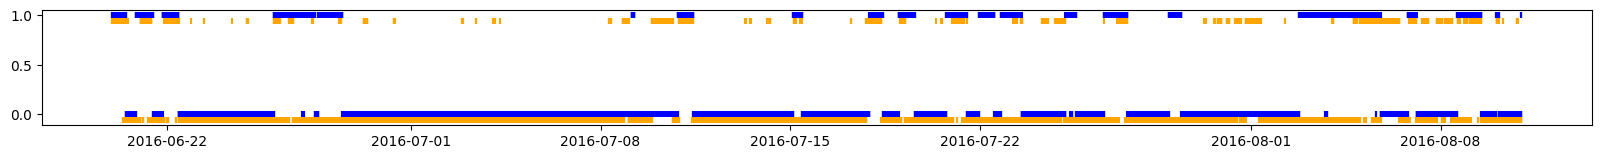

In [26]:
fig, ax = plt.subplots(figsize=(20, 1.5))
ax.scatter(mini_val['index'], mini_val[var_of_interest], s=25, color='blue', marker="|")
ax.scatter(mini_val['index'], mini_val['pred_tf']-.06, s=25, color='orange', marker="|")

plt.show()

In [27]:
data_united[X_val.index[0]:X_val.index[-1]].head()

,weir_level_cal,ra_rain,level_ro,raw_ro,obstruction_ro,gap_fill_ro,weir_cleaning_ro,spike_ro,calibration_ro,records_since_cal,...,1_deep,2_deep,3_deep,4_deep,5_deep,6_deep,7_deep,8_deep,9_deep,10_deep
2016-06-19 23:30:00,NaN,0.0,41.70,53.2,True,False,False,False,False,748.0,...,44.9,39.7,37.6,37.7,37.4,38.6,33.4,39.6,35.1,37.2
2016-06-19 23:35:00,NaN,0.0,41.59,53.2,True,False,False,False,False,749.0,...,44.9,39.7,37.6,37.7,37.4,38.6,33.4,39.6,35.1,37.2
2016-06-19 23:40:00,NaN,0.0,41.48,52.7,True,False,False,False,False,750.0,...,44.9,39.7,37.6,37.7,37.4,38.6,33.4,39.6,35.1,37.2
2016-06-19 23:45:00,NaN,0.0,41.37,52.7,True,False,False,False,False,751.0,...,44.9,39.7,37.6,37.7,37.4,38.6,33.4,39.6,35.1,37.2
2016-06-19 23:50:00,NaN,0.0,41.26,52.6,True,False,False,False,False,752.0,...,44.9,39.7,37.6,37.7,37.4,38.6,33.4,39.6,35.1,37.2


In [52]:
def plot_preds(input_date_start, input_date_end, include_preds=True, include_calibration=True):
    """Plot values between two dates in the style of the Visual FoxPro interface.

    Args:
        input_date_start (Timestamp): The start date.
        input_date_end (Timestamp): The end date.
        include_calibration (boolean): Include X-markers for the calibration points.
    
    Returns:
        Time series plot.
    """
    # Filter the data sets
    data_subset = data_united.copy()[input_date_start:input_date_end]
    # data_subset_rain = data_rainfall.loc[input_date_start:input_date_end]
    # data_subset_cal = data_calibration.loc[input_date_start:input_date_end]

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.axhline(y=0, color ='grey', linestyle = ':')
    # Plot the rain as a bar chart with a multiplier for visibility
    ax.vlines(data_subset.index, ymin=0, ymax=data_subset['ra_rain']*3, color = 'blue', label = "Rain (x3)")
    ax.plot(data_subset.index, data_subset['level_ro'], color = 'red', label = "Adjusted")
    ax.plot(data_subset.index, data_subset['raw_ro'], color = 'green', label = "Raw")
    # Include calibration points unless otherwise specified or unless there are none in the subset
    if include_calibration == True and not data_subset['weir_level_cal'].empty:
        ax.plot(data_subset.index, data_subset['weir_level_cal'], linestyle='none', marker='x', color='red', label = "Calibration")
    if include_preds == True:
        mini_val_subset = mini_val.copy().set_index('index')[input_date_start:input_date_end]
        ax.scatter(mini_val_subset.index, (mini_val_subset[var_of_interest]-3)*10, color='blue', marker="|")
        ax.scatter(mini_val_subset.index, (mini_val_subset['pred_tf']-5)*10, color='orange', marker="|")

    # Plot labels
    ax.set_xlabel("Date (YYYY-MM-DD)")
    ax.set_ylabel("Level (mm)")
    # ax.set_title('Simple Time Series Plot')
    ax.set_title("Runoff time series from " + str(input_date_start) + " through " + str(input_date_end))
    # ax.set_ylim(bottom=0) 
    # ax.grid(True)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # Reverse the order of the legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='upper right')
    # plt.legend(loc = 'upper right')
    return plt.show()

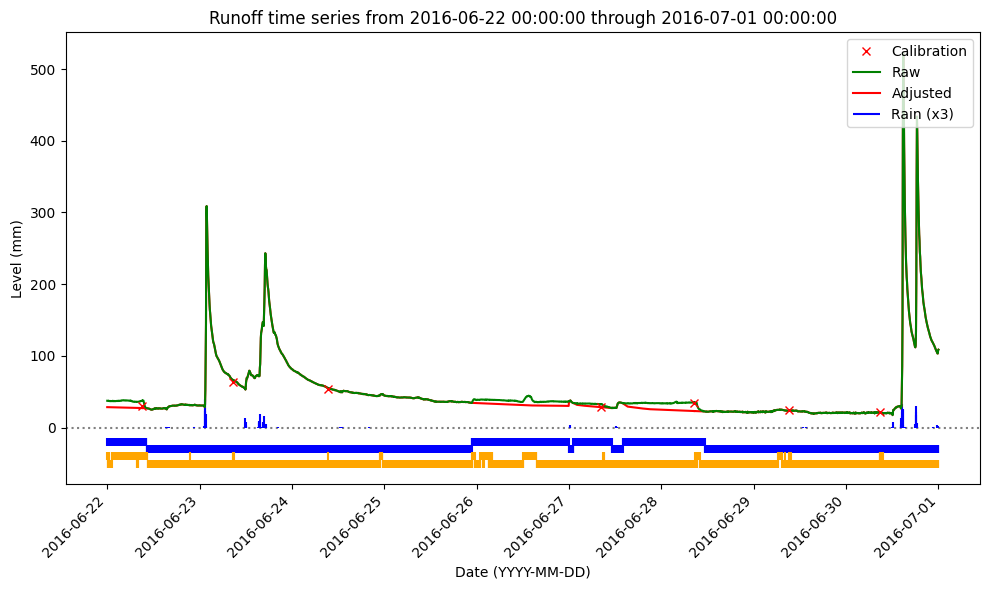

In [53]:
# plot_preds(X_val.index[0], X_val.index[-1])
plot_preds('2016-06-22 00:00:00', '2016-07-01 00:00:00')

In [ ]:
# data_subset = data_united[X_val.index[0]:X_val.index[-1]]

# fig, ax = plt.subplots(figsize=(10, 6))
# plt.axhline(y=0, color ='grey', linestyle = ':')
# # Plot the rain as a bar chart with a multiplier for visibility
# ax.vlines(data_subset.index, ymin=0, ymax=data_subset['ra_rain']*3, color = 'blue', label = "Rain (x3)")
# ax.plot(data_subset.index, data_subset['level_ro'], color = 'red', label = "Adjusted")
# ax.plot(data_subset.index, data_subset['raw_ro'], color = 'green', label = "Raw")
# # Include calibration points unless otherwise specified or unless there are none in the subset
# # if include_calibration == True and not data_subset_cal.empty:
# ax.plot(data_subset.index, data_subset['weir_level_cal'], linestyle='none', marker='x', color='red', label = "Calibration")

# # Plot labels
# ax.set_xlabel("Date (YYYY-MM-DD)")
# ax.set_ylabel("Level (mm)")
# # ax.set_title('Simple Time Series Plot')
# # ax.set_title("Runoff time series from " + input_date_start + " through " + input_date_end)
# # ax.set_ylim(bottom=0) 
# # ax.grid(True)
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# # Reverse the order of the legend
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[::-1], labels[::-1], loc='upper right')
# # plt.legend(loc = 'upper right')
# plt.show()

# del data_subset, fig, ax, handles, labels


Confusion Matrix:
 [[9711 1168]
 [2631 1467]] 
Precision:	 0.5567362428842505 
Recall:		 0.3579795021961933 
F1 Score:	 0.43576414673993763 
Accuracy:	 0.7463443947385991


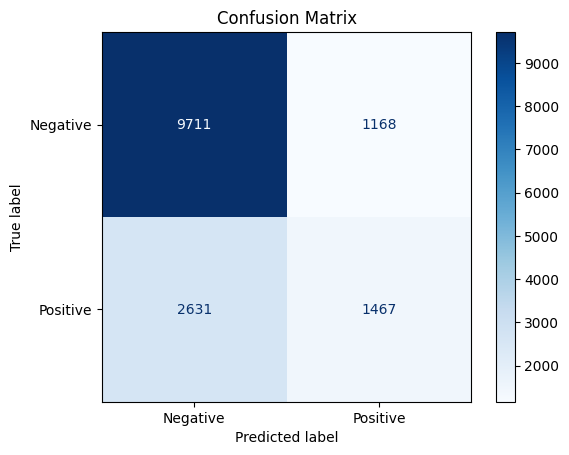

In [54]:
# f1_score, precision_score, recall_score, accuracy_score
y_true = mini_val[var_of_interest].tolist()
y_pred = mini_val['pred_tf'].tolist()

# Compute the confusion matrix
# cm = confusion_matrix(mini_val[var_of_interest].tolist(), mini_val['pred_tf'].tolist())
metric_cm = confusion_matrix(y_true, y_pred)
# print("Confusion Matrix:\n", metric_cm)

# Precision
metric_precision = precision_score(y_true, y_pred)


# Recall
metric_recall = recall_score(y_true, y_pred)

# F1
# f1_score = f1_score(mini_val[var_of_interest].tolist(), mini_val['pred_tf'].tolist())
metric_f1 = f1_score(y_true, y_pred)
# print("F1:\n", metric_f1)

# Accuracy - the total number of correct predictions performed by hte model
metric_accuracy = accuracy_score(y_true, y_pred)

print(
    "\nConfusion Matrix:\n", metric_cm,
    "\nPrecision:\t", metric_precision,
    "\nRecall:\t\t", metric_recall,
    "\nF1 Score:\t", metric_f1,
    "\nAccuracy:\t", metric_accuracy
)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=metric_cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Environment cleanup
del y_true, y_pred, metric_cm, metric_precision, metric_recall, metric_f1, metric_accuracy, disp